# Data Exploratie notebook

# Index
- 1. [Phase 1: Business Understanding](#1-business-understanding)
- 2. [Phase 2: Data Understanding](#data-understanding)
    - 2.1 [2.1 Basis analyse](#basis-anaylyse)
    - 2.2 [Skewness](#skewness)
    - 2.3 [Grafieken](#grafieken)
    - 2.4 [Correlaties en Scatter Matrix](#correlaties-scatter)
- 3. [Phase 3: Data Preparation](#data-prep)
    - 3.1 [Afwijkingen uit fase 2 onderzoeken en oplossen](#afwijkingen)
    - 3.2 [Keys feature](#keys-feature)
    - 3.3 [Uitschieters detecteren](#uitschieters)
    - 3.4 [Feature Engineering](#feature-eng)

<a id="business-understanding"></a>
# Phase 1: Business Understanding

Het doel van dit model is om te testen of populariteit van een nummer 
<br>
voorspelt kan worden met lineaire regressie o.b.v de audio-features 
<br>
in deze dataset. 

<a id="data-understanding"></a>
# Phase 2: Data Understanding

Alle afwijkingen uit deze fase worden verder onderzocht in de derde fase. 

In [395]:
# Modules importeren
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

In [396]:
df = pd.read_csv("/Users/odessa/Desktop/Applied Data Science & AI/Data Science/Code Inleiding data science/song_data.csv") # Dataset importeren 

<a id="basis-anaylyse"></a>
## 2.1 Basis analyse

In [397]:
display(df.head()) # eerste 5 rijen van de dataset weergeven

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [398]:
df.shape # rijen en kolommen tellen
print(f"De dataset bevat {df.shape[0]} rijen en {df.shape[1]} kolommen.")

De dataset bevat 18835 rijen en 15 kolommen.


In [399]:
df.info() # dtypes en null waarden bekijken

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


In [400]:
df.describe().T # Statistiche informatie weergeven over numerieke kolommen

,count,mean,std,min,25%,50%,75%,max
song_popularity,18835.0,52.991877,21.905654,0.000000,40.0000,56.000000,69.00000,100.000
song_duration_ms,18835.0,218211.587576,59887.540566,12000.000000,184339.5000,211306.000000,242844.00000,1799346.000
acousticness,18835.0,0.258539,0.288719,0.000001,0.0241,0.132000,0.42400,0.996
danceability,18835.0,0.633348,0.156723,0.000000,0.5330,0.645000,0.74800,0.987
energy,18835.0,0.644995,0.214101,0.001070,0.5100,0.674000,0.81500,0.999
instrumentalness,18835.0,0.078008,0.221591,0.000000,0.0000,0.000011,0.00257,0.997
key,18835.0,5.289196,3.614595,0.000000,2.0000,5.000000,8.00000,11.000
liveness,18835.0,0.179650,0.143984,0.010900,0.0929,0.122000,0.22100,0.986
loudness,18835.0,-7.447435,3.827831,-38.768000,-9.0440,-6.555000,-4.90800,1.585
audio_mode,18835.0,0.628139,0.483314,0.000000,0.0000,1.000000,1.00000,1.000


In [401]:
df.duplicated(subset=None).sum()

np.int64(3909)

### Observatie statistische informatie
Time_signature minimum = 0, kan niet volgens spotify API range: 3-7
<br>
Tempo minimum = 0, kan eigenlijk niet 
<br>
Deze punten worden aangepakt in fase 3 
<br>
audio_valence = 0, danceability = 0. Kan, maar even checken 

### Dubbele waardes bekijken

In [402]:
dubbel = pd.DataFrame({
    'Aantal dubbele waarden': [df[col].duplicated().sum() for col in df.columns],
    'Percentage dubbele waarden (%)': [
        round(df[col].duplicated().mean() * 100, 2) for col in df.columns
    ]
}, index=df.columns)
dubbel = dubbel.sort_values(by='Percentage dubbele waarden (%)', ascending=True)
print(dubbel)

                  Aantal dubbele waarden  Percentage dubbele waarden (%)
song_name                           5765                           30.61
tempo                               6723                           35.69
song_duration_ms                    7064                           37.50
loudness                           10419                           55.32
instrumentalness                   14910                           79.16
acousticness                       15626                           82.96
liveness                           17410                           92.43
audio_valence                      17589                           93.38
speechiness                        17611                           93.50
energy                             17703                           93.99
danceability                       17986                           95.49
song_popularity                    18734                           99.46
key                                18823           

### Observaties basis analyse 
Er zijn geen missende waardes. 
<br>
Alle features behalve song_name hebben numerieke waardes.
<br>
Er zijn veel dubbele waardes. Bij sommige kolommen is dit logisch (key, audio_mode, time_signature, song_popularity), bij anderen mogelijk onlogisch. 


## 2.2 Correlatie heatmap originele features

In [403]:
df_num = df.select_dtypes(include=['number']).copy() # Dataframe maken met alleen numerieke kolommen

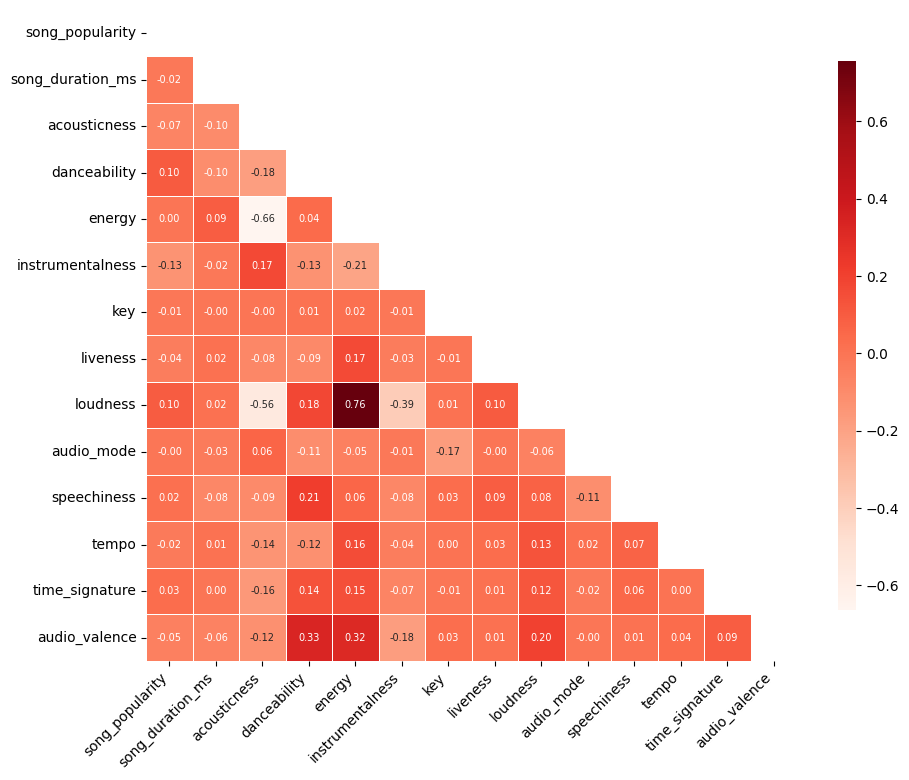

In [404]:
corr = df_num.corr()

n = len(corr.columns)
scale = 0.7   # pas aan om de grootte van de vakjes te wijzigen
size = min(14, n * scale)

f, ax = plt.subplots(figsize=(size, size))

# Masker voor bovenste helft
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Tekstgrootte voor annotaties
annot_size = max(6, 14 - n // 2)

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    linewidths=0.4,
    mask=mask,
    square=True,
    annot_kws={"size": annot_size},
    cbar_kws={"shrink": 0.6, "aspect": 30}  # <<< colorbar smaller maken
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('corrplot.png', dpi=600)
plt.show()

## 2.3 Distributies originele features 

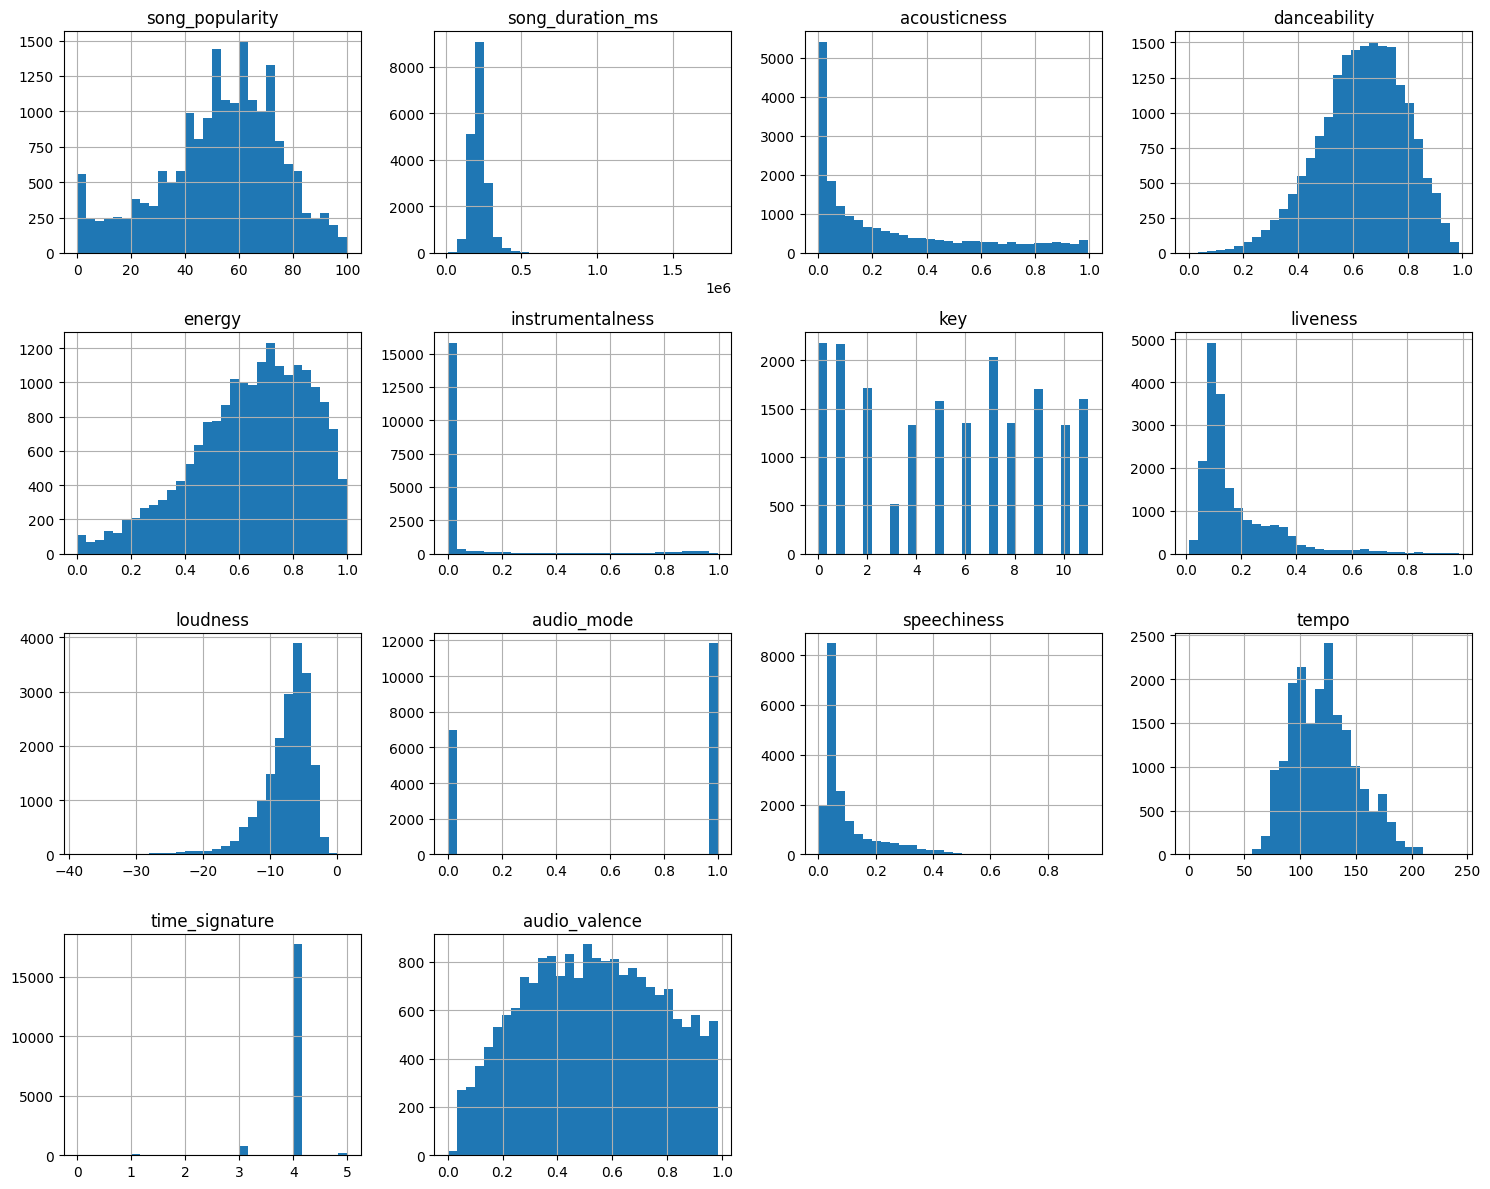

In [405]:
# Histogrammen van originele dataframe
df_num.hist(figsize=(15,12), bins=30)
plt.title("Distributie van numerieke featrures")
plt.tight_layout()
plt.show()

### Observatie histogrammen originele df 
right skewed: song_duration_ms, acousticness, liveness, speechiness 
<br>
left skewed: danceability, tempo 
<br>
Discrete features: audio_mode, time_signature, key(cyclisch)
<br>
Continue features: alle andere features
<br>
Skewness komt overeen met skewness berekeningen

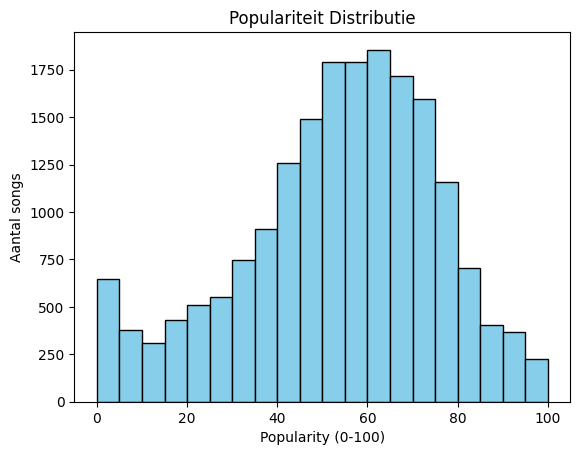

In [406]:
# Plot popularity distribution
plt.hist(df["song_popularity"], bins=20, color="skyblue", edgecolor="black")
plt.title("Populariteit Distributie")
plt.xlabel("Popularity (0-100)")
plt.ylabel("Aantal songs")
plt.show()

### Observatie populariteit distributie
Piek tussen 50 en 75.

## 2.4 Feature Engineering

In [407]:
def nieuwe_features(df):
    df = df.copy()
    
    # Basisfeatures
    df['valence_dance'] = df['audio_valence'] * df['danceability']
    df['acoustic_dance_ratio'] = df['acousticness'] / (df['danceability'] + 0.001)
    df['duration_energy_ratio'] = df['song_duration_ms'] / (df['energy'] + 0.001)
    
    # Nieuwe interacties
    df['energy_tempo'] = df['energy'] * df['tempo']
    df['acoustic_valence'] = df['acousticness'] * df['audio_valence']
    df['liveness_tempo'] = df['liveness'] * df['tempo']
    df['duration_energy'] = df['song_duration_ms'] * df['energy']
    df['valence_acoustic_dance'] = df['valence_dance'] * df['acoustic_dance_ratio']
    
    return df

## 2.5 Distributies nieuwe features 

New features added:
 ['valence_dance', 'acoustic_dance_ratio', 'duration_energy_ratio', 'energy_tempo', 'acoustic_valence', 'liveness_tempo', 'duration_energy', 'valence_acoustic_dance']


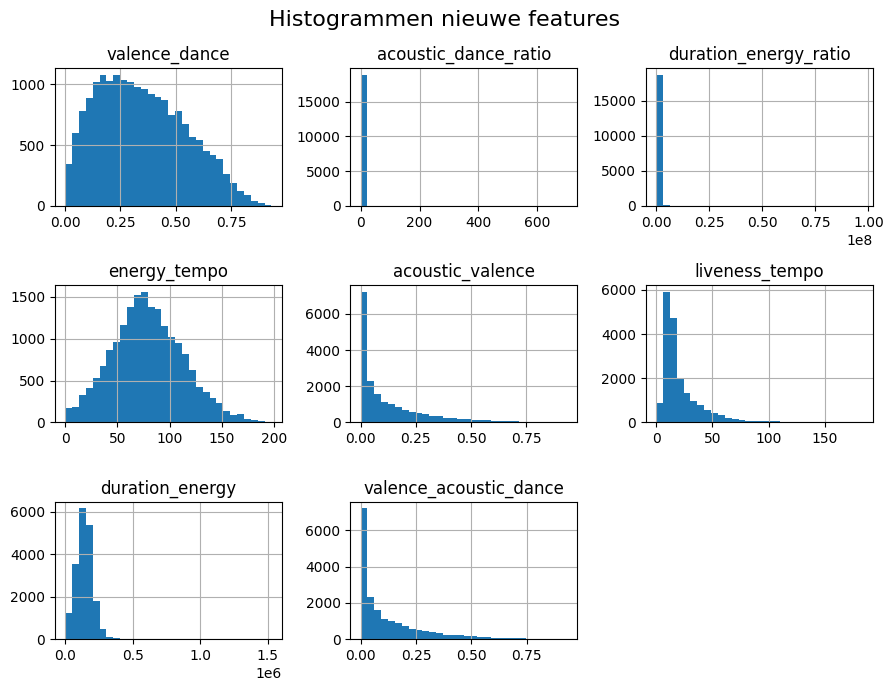

In [408]:
df_num_features = nieuwe_features(df_num.copy())

new_cols = [c for c in df_num_features.columns if c not in df_num.columns]
print("New features added:\n", new_cols)

df_explore = df_num_features.copy()
df_explore['song_popularity'] = df['song_popularity']

df_num_features[new_cols].hist(figsize=(9,7), bins=30)
plt.suptitle("Histogrammen nieuwe features", fontsize=16)
plt.tight_layout()
plt.show()

### Observatie histogrammen nieuwe features
rechts-scheef: acoustic_dance_ratio en duration_energy_ratio

## Mutual information nieuwe features 

In [409]:
from sklearn.feature_selection import mutual_info_regression
X = df_explore[new_cols]
y = df_explore['song_popularity']

mi_scores = mutual_info_regression(X, y, random_state=42)

mi_df = pd.DataFrame({'Feature': new_cols, 'Mutual Information': mi_scores})
mi_df.sort_values(by='Mutual Information', ascending=False, inplace=True)

print("\nMutual Information Scores (niet-lineaire feature relevantie):\n")
display(mi_df)

threshold = 0.02
selected_features = mi_df.loc[mi_df['Mutual Information'] > threshold, 'Feature'].tolist()


Mutual Information Scores (niet-lineaire feature relevantie):



,Feature,Mutual Information
7,valence_acoustic_dance,0.654688
4,acoustic_valence,0.654036
6,duration_energy,0.646150
5,liveness_tempo,0.642872
3,energy_tempo,0.638749
1,acoustic_dance_ratio,0.637369
0,valence_dance,0.635966
2,duration_energy_ratio,0.629442


<a id="skewness"></a>
## 2.6 Skewness

https://samawat-ai.medium.com/skewness-and-kurtosis-c571fc4e0c0f

In [410]:
from scipy.stats import skew 
from scipy.stats import kurtosis

In [411]:
# Functie Skewness en kurtosis berekenen en highlighten van hoog scheef, matig scheef en redelijk symmetrisch 
def skewness_kurtosis(df):
    skewness = df.skew(numeric_only=True)
    kurtosis = df.kurt(numeric_only=True)

    stats_skew_kurt = pd.DataFrame({
        'skewness': skewness,
        'kurtosis': kurtosis
    })

    def highlighter(rij):
        skew = rij['skewness']
        color = ''
        if abs(skew) > 1: # Hoge scheefheid (groter dan 1 of kleiner dan -1) kleur = rood 
            color = 'background-color: red; color: black;'
        elif 0.5 < abs(skew) <=1: # Matige scheefheid (scheefheid tussen -1 en -0.5 of tussen 0.5 en 1) kleur = blauw 
            color = 'background-color: #336df5; color: black;'
        elif abs(skew) <= 0.5: # Redelijk symmetrische distributie (scheefheid tussen -0.5 en 0.5) geen highlight
            color = 'color: white;'
        return ['' if c != 'skewness' else color for c in stats_skew_kurt.columns]
    
    styled = stats_skew_kurt.style.apply(highlighter, axis=1)
    display(styled)
    return stats_skew_kurt

In [412]:
df_num = nieuwe_features(df_num)

### Skewness originele + engineered features

In [413]:
stats = skewness_kurtosis(df_num)
skewed_cols = stats.loc[stats['skewness'].abs() > 1].index.tolist()
print("Sterk scheve kolommen:", skewed_cols)

,skewness,kurtosis
song_popularity,-0.501487,-0.169104
song_duration_ms,3.257477,46.708949
acousticness,1.071164,-0.096276
danceability,-0.391719,-0.074797
energy,-0.620738,-0.137875
instrumentalness,2.985176,7.563664
key,-0.002520,-1.311466
liveness,2.215423,5.789919
loudness,-1.929511,6.522480
audio_mode,-0.530308,-1.718956


Sterk scheve kolommen: ['song_duration_ms', 'acousticness', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'time_signature', 'acoustic_dance_ratio', 'duration_energy_ratio', 'acoustic_valence', 'liveness_tempo', 'duration_energy', 'valence_acoustic_dance']


De skewness-analyse (zie tabel hierboven) bevestigt dat song_duration_ms, acousticness, liveness en speechiness sterk rechts-scheef zijn, en danceability en tempo licht links-scheef.

### Observatie skewness originele en nieuwe features 
originele features: 'song_duration_ms', 'acousticness', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'time_signature' zijn scheef verdeeld. 
<br>
rechts scheef: song_duration_ms, acousticness, liveness, speechiness -> log transformatie
<br>
links scheef : danceability, tempo -> yeo johnson transformatie 
<br>
nieuwe features: 'acoustic_dance_ratio' en 'duration_energy_ratio' zijn rechts scheef. -> log transformatie gebruiken 

In [414]:
from itertools import combinations
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import pandas as pd

# Alleen numerieke features gebruiken
X_num = df_num.select_dtypes(include=[np.number]).drop(columns=['song_popularity'], errors='ignore').copy()
y = df['song_popularity']

# Alle paren van features
pairs = list(combinations(X_num.columns, 2))
scores = []

for f1, f2 in pairs:
    combo = X_num[f1] * X_num[f2]  # interactie als product
    mi = mutual_info_regression(combo.values.reshape(-1, 1), y, random_state=42)[0]
    scores.append((f1, f2, mi))

# Sorteren op mutual information
mi_df = pd.DataFrame(scores, columns=['feature_1', 'feature_2', 'mutual_info'])
mi_df = mi_df.sort_values('mutual_info', ascending=False)

print("Top 10 meest informatieve feature-interacties:\n")
display(mi_df.head(10))

Top 10 meest informatieve feature-interacties:



,feature_1,feature_2,mutual_info
182,valence_dance,acoustic_dance_ratio,0.657644
30,acousticness,audio_valence,0.656006
173,time_signature,valence_acoustic_dance,0.655349
70,energy,acoustic_valence,0.655279
73,energy,valence_acoustic_dance,0.654913
206,acoustic_valence,valence_acoustic_dance,0.653867
170,time_signature,acoustic_valence,0.653032
175,audio_valence,acoustic_dance_ratio,0.651878
127,loudness,energy_tempo,0.648419
50,danceability,acoustic_dance_ratio,0.646935


In [415]:
cat_cols = ['key', 'audio_mode', 'time_signature']
num_cols = df_num.drop(columns=cat_cols).columns

<a id="correlaties-scatter"></a>
## Correlaties en Scatter Matrix

## 2.7 Correlatie heatmap originele + engineered features 

0.00 – 0.30	nauwelijks of geen correlatie
<br>
0.30 – 0.50	lage of zwakke correlatie
<br>
0.50 – 0.70	middelmatige correlatie
<br>
0.70 – 0.90	hoge of sterke correlatie
<br>
0.90 – 1.00	zeer hoge of zeer sterke correlatie

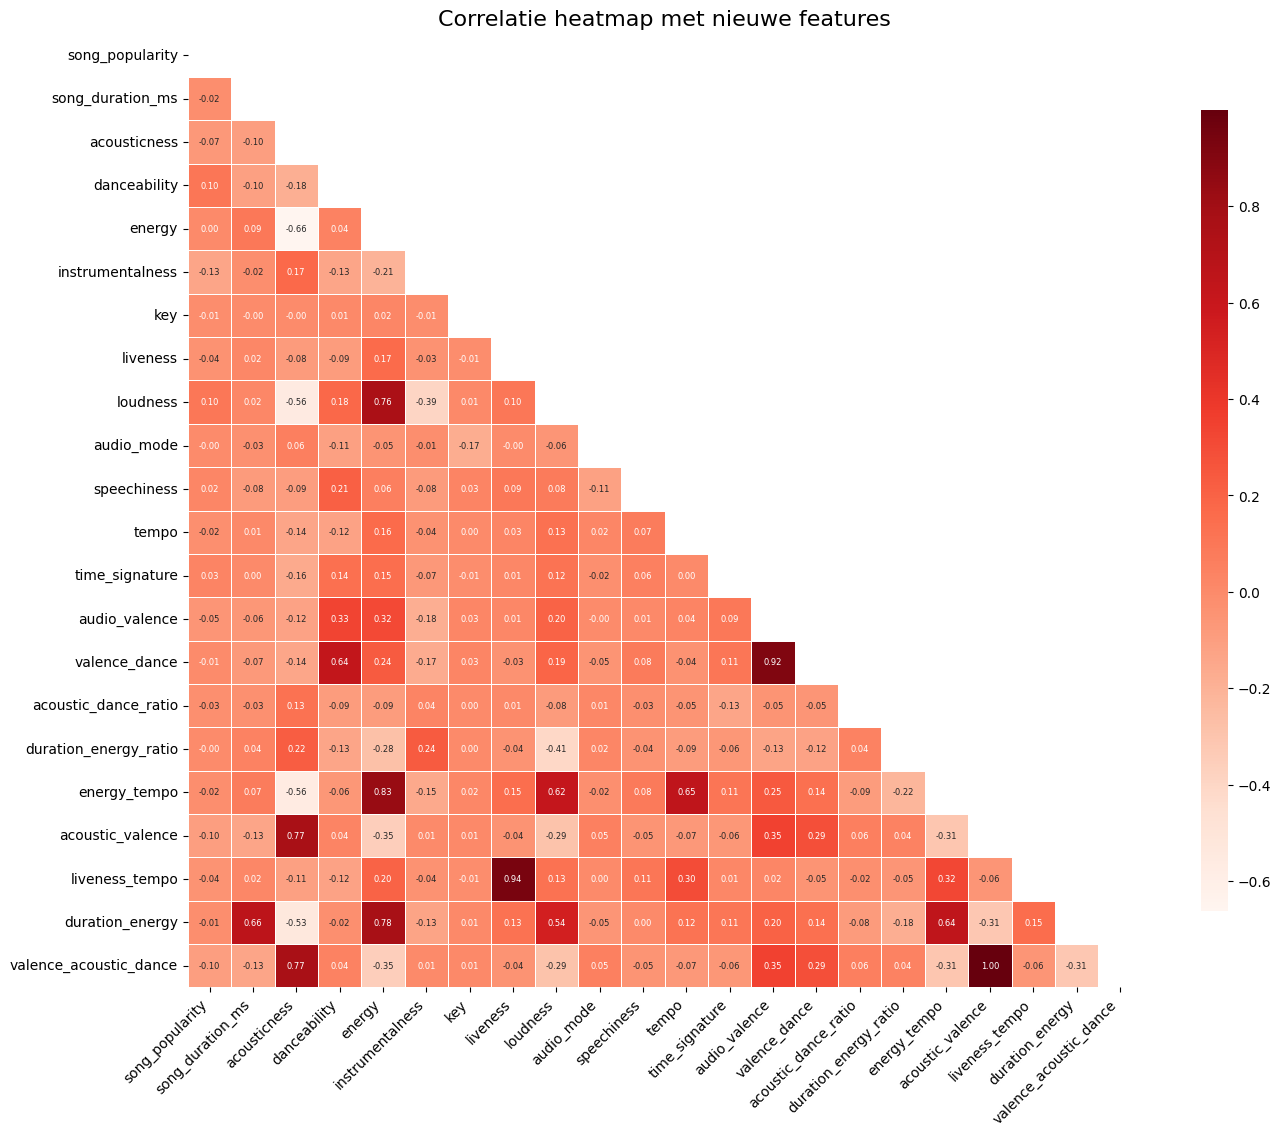

In [416]:
corr = df_num_features.corr()

# Schaal en figuurgrootte bepalen
n = len(corr.columns)
scale = 0.7
size = min(14, n * scale)
f, ax = plt.subplots(figsize=(size, size))  # gebruik size i.p.v. n*scale voor begrenzing

# Masker voor bovenste helft
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Lettergrootte aanpassen aan aantal kolommen
annot_size = max(6, 16 - n // 2)

# Heatmap tekenen
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    linewidths=0.4,
    mask=mask,
    square=True,
    annot_kws={"size": annot_size},
    cbar_kws={"shrink": 0.6, "aspect": 30}  # <<< colorbar smaller maken
)

# Titel, assen en layout
plt.title("Correlatie heatmap met nieuwe features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

  danceability heeft de hoogste correlatie met song_popularity 
 <br>
 energy en acousticness hebben een redelijk sterke negatieve correlatie: -0.68
 <br>
 loudness en acousticness hebben een negatieve correlatie: -0.57 
 <br>
 loudness en instrumentalness hebben een negatieve correlatie: -0.4
 <br>
loudness en energy hebben een sterke positieve correlatie: 0.77

## 2.8 Scatter matrix 

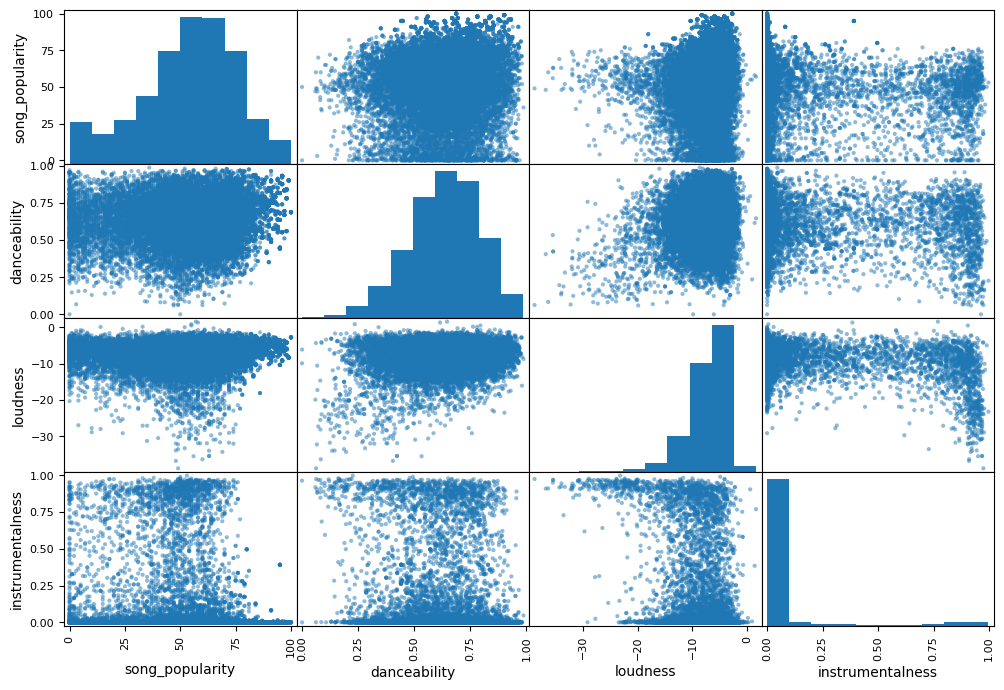

In [417]:
attributes = ['song_popularity', 'danceability', 'loudness', 'instrumentalness']
scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()

### Observatie correlatie heatmap en scatter matrices
De feature met de hoogste correlatie met song_popularity is danceability. 
<br>
Deze correlatie is 0.1. Erg laag 

<a id="data-prep"></a>
# Phase 3: Data Preparation

Afwijkingen fase 2 onderzoeken en data klaar maken voor training

#### Rijen waar zowel song_name als song_duration_ms dubbel zijn droppen 

In [418]:
print(f"Totaal aantal waardes in de dataframe vóór het verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}")

# Dubbele waardes droppen van song_name en song_duration 
# Als ik alleen song_name duplicates zou verwijderen, zou ik misschien covers van nummers verwijderen, dus daarom check ik ook de song_duration 
df.drop_duplicates(subset=['song_name', 'song_duration_ms'], inplace = True)
print(f"Totaal aantal waardes in de dataframe na verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}")

Totaal aantal waardes in de dataframe vóór het verwijderen van dubbele waardes uit song_name en song_duration_ms: 18835
Totaal aantal waardes in de dataframe na verwijderen van dubbele waardes uit song_name en song_duration_ms: 14468


In [419]:
df_num_cleaned = df.select_dtypes(include=['number']).copy()

#### Time signature

In [420]:
df_num_cleaned["time_signature"].value_counts()

time_signature
4    13535
3      675
5      192
1       63
0        3
Name: count, dtype: int64

time_signature gaat van 3 tot 7 volgens de Spotify API. 
<br>
Waardes van 1 en 0 zijn foute waardes. 

In [421]:
# Indexen van time_signature == 0 
time_sig_is_zero = df_num_cleaned[df_num_cleaned['time_signature'] == 0]

# Indexen van time_signature == 1
time_sig_is_one = df_num_cleaned[df_num_cleaned['time_signature'] == 1]

# Dataframe maken van time_signatures 0 en 1 
df_time_signature_0_1 = pd.concat([time_sig_is_zero, time_sig_is_one])

# Statistische berekeningen zien van waardes met time signatures van 0 en 1 
display(df_time_signature_0_1.describe()) 

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.00000,66.000000,66.000000,66.000000,66.000000
mean,45.606061,198070.166667,0.496574,0.473561,0.499382,0.248995,5.075758,0.182830,-9.905955,0.69697,0.137626,101.294924,0.954545,0.344342
std,19.970654,62598.633341,0.348572,0.183958,0.249554,0.378419,3.574743,0.150138,5.165663,0.46309,0.152235,36.120564,0.209895,0.235870
min,0.000000,12000.000000,0.000001,0.000000,0.003790,0.000000,0.000000,0.064000,-29.298000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,36.750000,171092.250000,0.155750,0.356250,0.304500,0.000000,2.000000,0.100425,-11.767750,0.00000,0.033700,79.101750,1.000000,0.158250
50%,50.000000,188785.000000,0.504000,0.505500,0.493000,0.001480,5.000000,0.123000,-9.009500,1.00000,0.053200,94.063000,1.000000,0.309000
75%,60.000000,224910.250000,0.807750,0.603750,0.677250,0.655500,8.000000,0.217000,-6.488500,1.00000,0.201000,117.001000,1.000000,0.498750
max,79.000000,435040.000000,0.991000,0.833000,0.992000,0.963000,11.000000,0.944000,-3.127000,1.00000,0.663000,200.729000,1.000000,0.908000


Omdat meerdere waardes afwijken: tempo, audio_valence, time_signature, speechiness, instrumentalness, danceability en song_popularity hebben allemaal een minimum van 0.0.
<br>
Bij sommige features zou een minimum van 0.0 theoretisch kunnen, maar de kans dat tempo een 0.0 minimum heeft kan bijvoorbeeld eigenlijk niet, want een liedje kan niet geen tempo hebben. 
<br>
Omdat er in totaal maar 66 rijen zijn met een time_signature van 1 of 0, heb ik ervoor gekozen om deze rijen allemaal te droppen. 

In [422]:
df = df[df['time_signature'] > 1]
df_num = df_num[df_num['time_signature'] > 1]
df_num_cleaned = df_num_cleaned[df_num_cleaned['time_signature'] > 1]

#### Tempo 

In [423]:
# Nummers met een tempo van 0. 
nul_tempo = df_num_cleaned.loc[df_num_cleaned['tempo'] == 0, ['tempo', 'song_popularity']]
print(f'Nummers met een tempo van 0: {nul_tempo}')

# Tempo == 0 is opgelost na verwijderen van dubbele waardes en time_signature 0 en 1

Nummers met een tempo van 0: Empty DataFrame
Columns: [tempo, song_popularity]
Index: []


#### Danceability 

In [424]:
df_num_cleaned['danceability'].value_counts()

danceability
0.6570    48
0.5650    47
0.6110    47
0.6870    46
0.6000    46
          ..
0.1310     1
0.0962     1
0.1860     1
0.9700     1
0.1800     1
Name: count, Length: 846, dtype: int64

<a id="keys-feature"></a>
### Keys feature

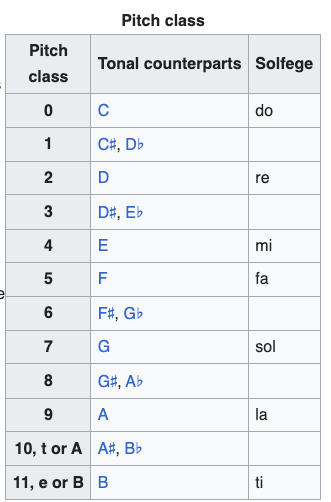

Dit is circulair: 12 en 0 zijn dezelfde toonsoort. 

0 (C) en 11 (B)  liggen numeriek ver uit elkaar, maar muzikaal liggen ze recht naast elkaar 


https://towardsdatascience.com/cyclical-encoding-an-alternative-to-one-hot-encoding-for-time-series-features-4db46248ebba/

https://medium.com/@axelazara6/why-we-need-encoding-cyclical-features-79ecc3531232

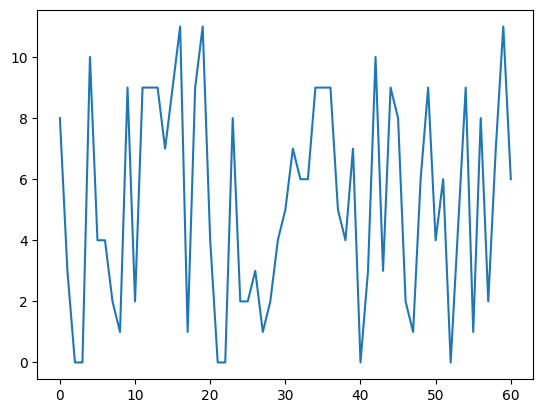

In [425]:
# Plotten van key met sample van de eerste 60 data 
sample = df_num_cleaned[:60]
ax = sample['key'].plot()

In [426]:
# Handmatig cyclisch encoden 
df_num_cleaned['key_sin'] = np.sin(2*np.pi*df_num_cleaned['key']/12)
df_num_cleaned['key_cos'] = np.cos(2*np.pi*df_num_cleaned['key']/12)

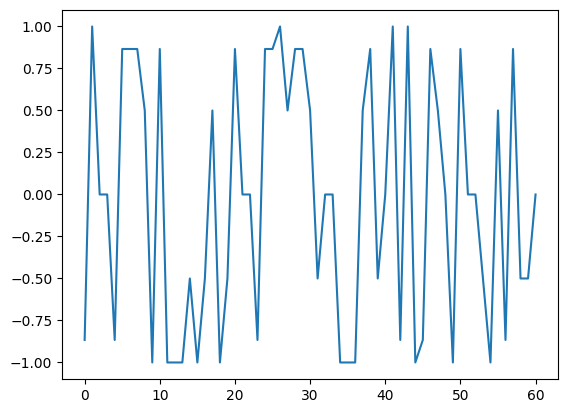

In [427]:
# Plotten van key met eerste 60 data na cyclisch encoden. 
sample = df_num_cleaned[:60]
ax = sample['key_sin'].plot()

De schaal is veranderd naar -1 tot +1 

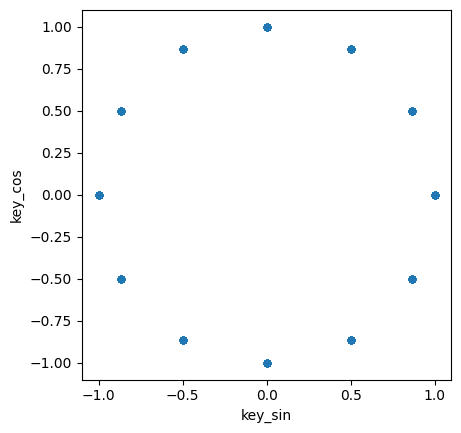

In [428]:
# Plot twee dimensioneel perspectief 
ax = df_num_cleaned.plot.scatter('key_sin', 'key_cos').set_aspect('equal')

<a id="uitschieters"></a>
## Uitschieters detecteren en verwijderen

In [429]:
def uitschieters(df):
    """ Markeert uitschieters."""

    df = df.copy()
    df_outliers = pd.DataFrame(index=df.index)

    # song_duration_ms — <30 sec of >20 min (vind ik te onwaarschijnlijk dat het dan een liedje is)
    df_outliers['song_duration_ms'] = (
        (df['song_duration_ms'] < 30_000) | 
        (df['song_duration_ms'] > 1_200_000)
    )

    # tempo — 30–250 BPM (o.b.v https://en.wikipedia.org/wiki/Tempo))
    df_outliers['tempo'] = (df['tempo'] < 30) | (df['tempo'] > 250)

    # loudness — normaal tussen -60 en 0 dB
    df_outliers['loudness'] = (df['loudness'] < -60) | (df['loudness'] > 0)

    # features met een range van 0-1 volgens Spotify API
    for col in ['danceability', 'energy', 'audio_valence', 'instrumentalness', 'liveness', 'speechiness']:
        if col in df.columns:
            df_outliers[col] = (df[col] < 0) | (df[col] > 1)

    # time_signature — meestal 3, 4 of 5
    if 'time_signature' in df.columns:
        df_outliers['time_signature'] = ~df['time_signature'].isin([3, 4, 5])

    # Samenvattende indicator: True als een rij minstens één outlier heeft
    df['is_uitschieter'] = df_outliers.any(axis=1)

    removed = df['is_uitschieter'].sum()
    pct = 100 * removed / len(df)
    print(f"Verwijderd: {removed} rijen ({pct:.2f}%)")
    
    return df[~df['is_uitschieter']]

In [430]:
df_num_cleaned = uitschieters(df_num_cleaned).drop(columns='is_uitschieter')
print(f"Dataframe grootte na verwijderen uitschieters: {df_num_cleaned.shape}")

Verwijderd: 11 rijen (0.08%)
Dataframe grootte na verwijderen uitschieters: (14391, 16)


In [431]:
df_num_cleaned = nieuwe_features(df_num_cleaned)

## Transformaties

Log-transformatie: song_duration_ms, acousticness, liveness, speechiness, acoustic_dance_ratio en duration_energy_ratio 
<br>
Yeo-johnson: danceability, tempo

### Log transformation

New features added:
 ['valence_dance', 'acoustic_dance_ratio', 'duration_energy_ratio']

In [432]:
stats = skewness_kurtosis(df_num_cleaned)
skewed_cols = stats.loc[stats['skewness'].abs() > 1].index.tolist()
print("Sterk scheve kolommen:", skewed_cols)

,skewness,kurtosis
song_popularity,-0.569358,-0.159652
song_duration_ms,1.871224,11.632053
acousticness,0.982612,-0.342558
danceability,-0.388833,-0.091083
energy,-0.599718,-0.261397
instrumentalness,2.644802,5.519851
key,-0.012123,-1.297956
liveness,2.213528,5.780948
loudness,-1.867388,5.895292
audio_mode,-0.544038,-1.704260


Sterk scheve kolommen: ['song_duration_ms', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'time_signature', 'acoustic_dance_ratio', 'duration_energy_ratio', 'acoustic_valence', 'liveness_tempo', 'valence_acoustic_dance']


In [433]:
# Log-transformatie op geselecteerde kolommen
log_cols = [
    'song_duration_ms', 'instrumentalness', 'liveness', 'speechiness',
    'acoustic_dance_ratio', 'duration_energy_ratio',
    'liveness_tempo', 'valence_acoustic_dance'
]

# 1️⃣ Kopie maken van de originele data
df_log = df_num_cleaned[log_cols].copy()

# 2️⃣ Log-transformatie
df_log_transformed = np.log1p(df_log)

# 3️⃣ Standaardiseren
scaler = StandardScaler()
scaled_data_log = scaler.fit_transform(df_log_transformed)

# 4️⃣ Nieuwe DataFrame met getransformeerde en geschaalde waarden
scaled_df_log = pd.DataFrame(scaled_data_log, columns=log_cols, index=df_log.index)

### Yeo-Johnson transformation

In [434]:
yeo_cols = [
    'danceability', 'audio_valence', 'energy', 'loudness',
    'acoustic_valence'
]

df_yeo = df_num_cleaned[yeo_cols]

In [435]:
pt = PowerTransformer(method='yeo-johnson')
transformed_data_yeo = pt.fit_transform(df_yeo)
transformed_df_yeo = pd.DataFrame(transformed_data_yeo, columns = df_yeo.columns, index=df_yeo.index)

In [436]:
scaler = StandardScaler()
scaled_data_yeo = scaler.fit_transform(transformed_df_yeo)
scaled_df_yeo = pd.DataFrame(scaled_data_yeo, columns=transformed_df_yeo.columns, index=transformed_df_yeo.index)

In [437]:
# Skewness en kurtosis van df_num_cleaned yeo cols vóór Power transformatie 
org_cols = ['danceability', 'audio_valence', 'energy', 'loudness', 'instrumentalness', 'liveness', 'speechiness','acoustic_dance_ratio', 'duration_energy_ratio']
stats_origineel = skewness_kurtosis(df_num_cleaned[org_cols])
skewed_cols = stats_origineel.loc[stats_origineel['skewness'].abs() > 1].index.tolist()
print("Sterk scheve kolommen vóór Yeo-Johnson:", skewed_cols)

,skewness,kurtosis
danceability,-0.388833,-0.091083
audio_valence,-0.028248,-0.992461
energy,-0.599718,-0.261397
loudness,-1.867388,5.895292
instrumentalness,2.644802,5.519851
liveness,2.213528,5.780948
speechiness,2.417429,7.613026
acoustic_dance_ratio,5.042710,53.352486
duration_energy_ratio,22.540407,656.020406


Sterk scheve kolommen vóór Yeo-Johnson: ['loudness', 'instrumentalness', 'liveness', 'speechiness', 'acoustic_dance_ratio', 'duration_energy_ratio']


In [438]:
# Skewness en kurtosis van df na yeo johnson transformatie 
stats_transformed = skewness_kurtosis(transformed_df_yeo)
skewed_cols_after = stats_transformed.loc[stats_transformed['skewness'].abs() > 1].index.tolist()
print("Sterk scheve kolommen ná Yeo-Johnson:", skewed_cols_after)

,skewness,kurtosis
danceability,-0.034407,-0.416457
audio_valence,-0.050113,-0.986564
energy,-0.122022,-0.852389
loudness,0.006724,0.344821
acoustic_valence,0.395016,-1.271205


Sterk scheve kolommen ná Yeo-Johnson: []


Niet meer skewed na yeo johnson transformatie

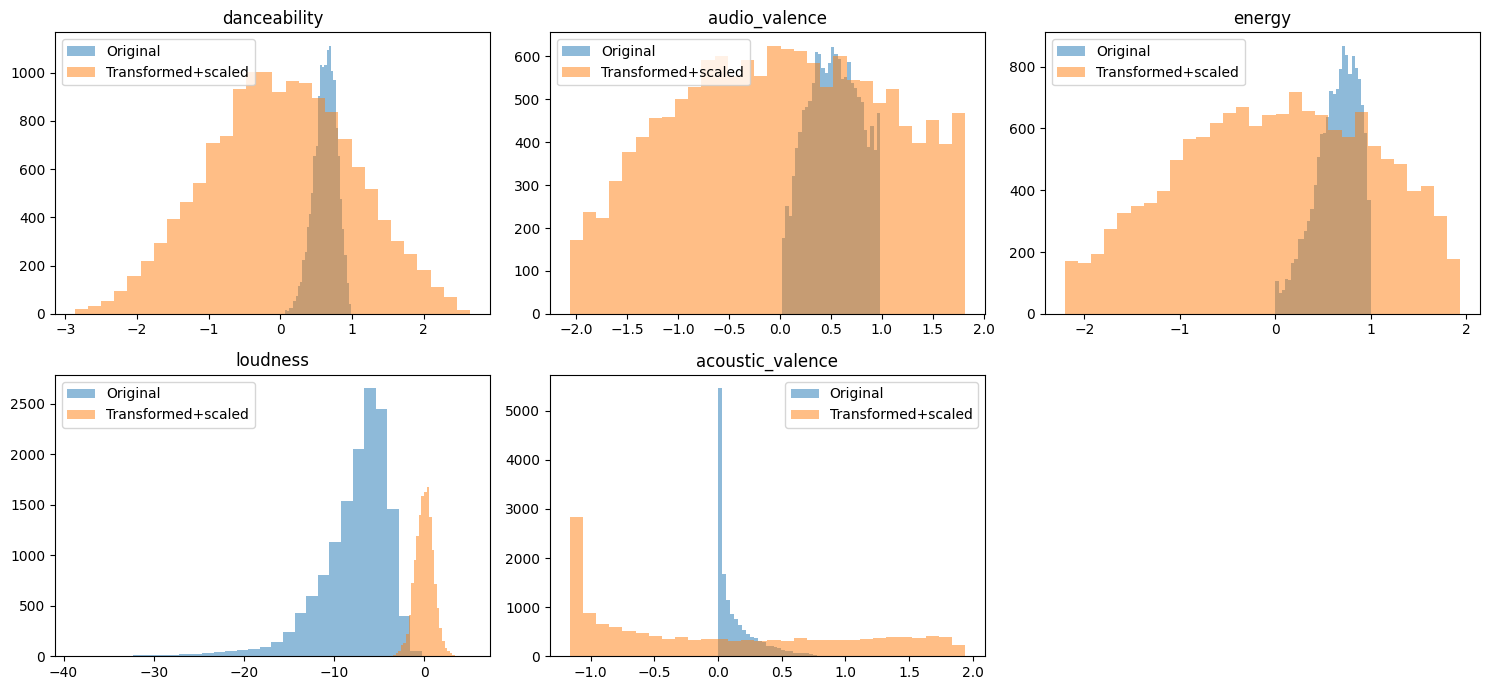

In [439]:
# Transformed + Scaled data histogrammen 
cols = df_yeo.columns
n_cols = 3  # how many plots per row
n_rows = int(np.ceil(len(cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 7))
axes = np.atleast_2d(axes)

for i, col in enumerate(cols):
    r, c = divmod(i, n_cols)
    ax = axes[r, c]

    # Plot original
    ax.hist(df_num_cleaned[col], bins=30, alpha=0.5, label='Original')
    # Plot transformed
    ax.hist(scaled_df_yeo[col], bins=30, alpha=0.5, label='Transformed+scaled')

    ax.set_title(col)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    r, c = divmod(j, n_cols)
    axes[r, c].axis('off')

plt.tight_layout()

plt.show()

dancability, energy, audio valence en mogelijk loudnesss worden beter van yeo johnson transformatie, de rest niet. 

In [440]:
# Combineer log-transformaties + geschaalde Yeo-Johnson features
df_final = df_num_cleaned.copy()
df_final[yeo_cols] = scaled_df_yeo[yeo_cols]

In [441]:
stats = skewness_kurtosis(df_final)
skewed_cols = stats.loc[stats['skewness'].abs() > 1].index.tolist()
print("Sterk scheve kolommen:", skewed_cols)

,skewness,kurtosis
song_popularity,-0.569358,-0.159652
song_duration_ms,1.871224,11.632053
acousticness,0.982612,-0.342558
danceability,-0.034407,-0.416457
energy,-0.122022,-0.852389
instrumentalness,2.644802,5.519851
key,-0.012123,-1.297956
liveness,2.213528,5.780948
loudness,0.006724,0.344821
audio_mode,-0.544038,-1.704260


Sterk scheve kolommen: ['song_duration_ms', 'instrumentalness', 'liveness', 'speechiness', 'time_signature', 'acoustic_dance_ratio', 'duration_energy_ratio', 'liveness_tempo', 'valence_acoustic_dance']


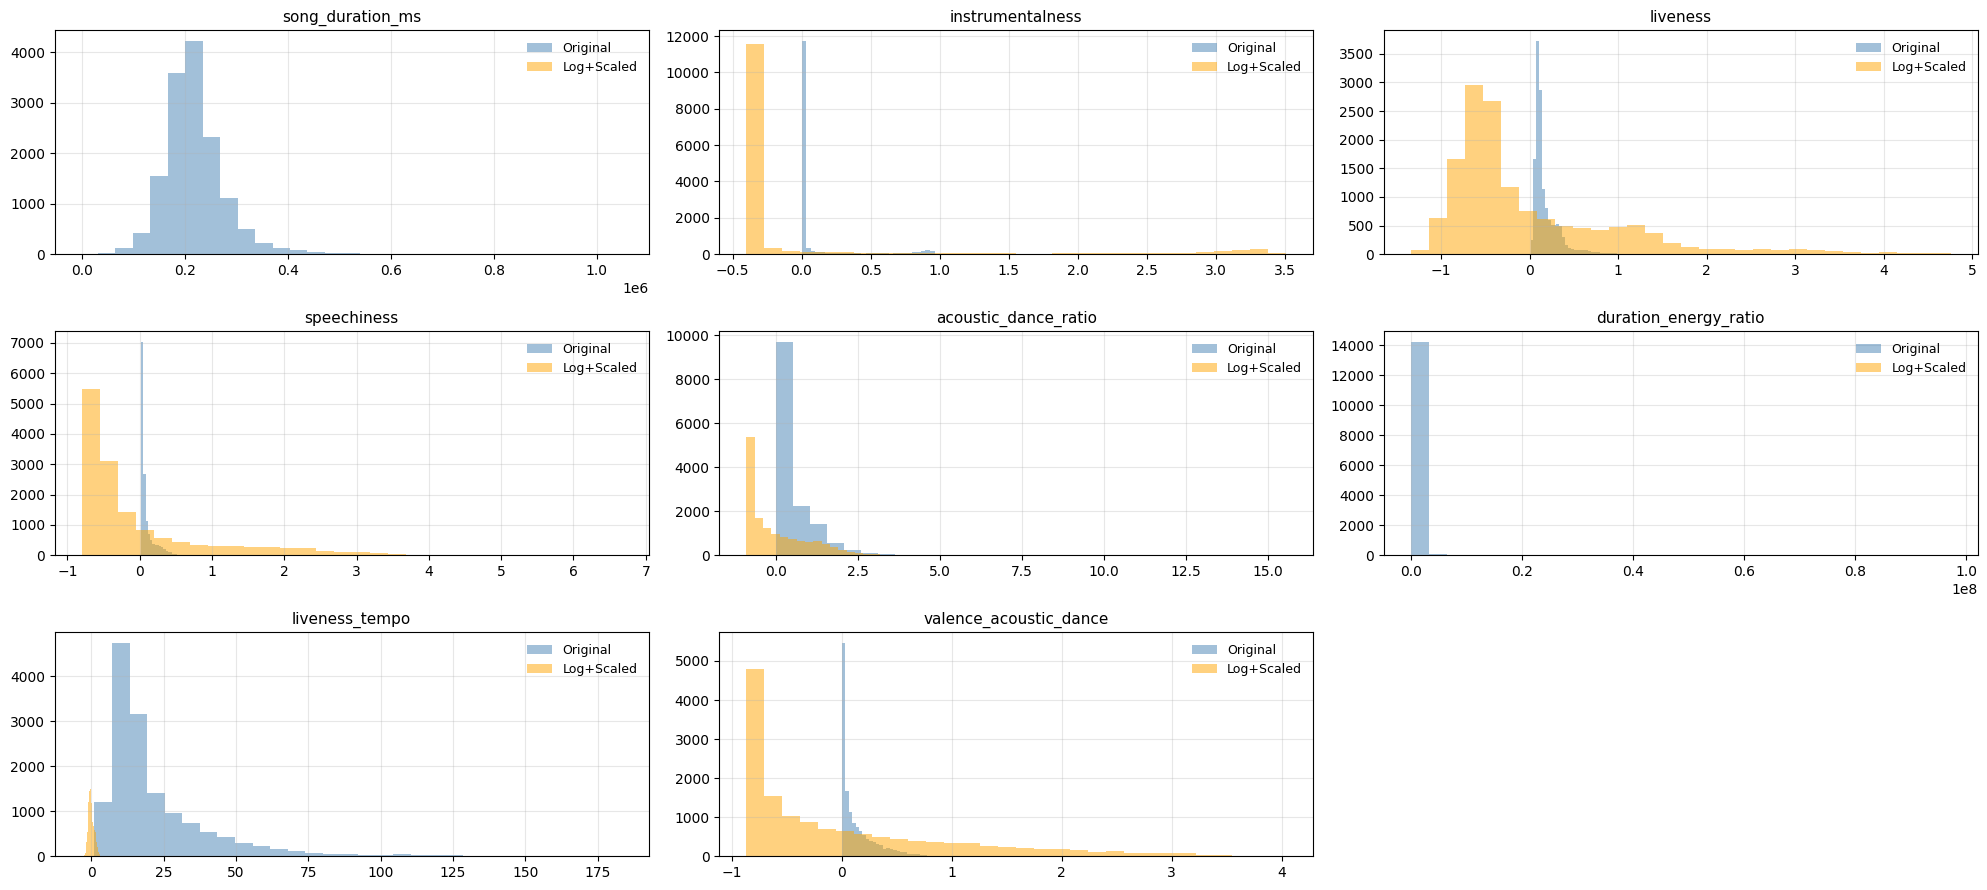

In [443]:
cols = log_cols
n_cols = 3
n_rows = int(np.ceil(len(cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
axes = np.atleast_2d(axes)

for i, col in enumerate(cols):
    r, c = divmod(i, n_cols)
    ax = axes[r, c]

    ax.hist(df_num_cleaned[col].dropna(), bins=30, alpha=0.5, color='steelblue', label='Original')
    ax.hist(scaled_df_log[col].dropna(), bins=30, alpha=0.5, color='orange', label='Log+Scaled')

    ax.set_title(col, fontsize=11)
    ax.legend(frameon=False, fontsize=9)
    ax.grid(alpha=0.3)

for j in range(i + 1, n_rows * n_cols):
    r, c = divmod(j, n_cols)
    axes[r, c].axis('off')

plt.tight_layout()
plt.show()

In [444]:
df_num_cleaned['song_duration_ms'].describe()


count    1.439100e+04
mean     2.187875e+05
std      6.013975e+04
min      3.137300e+04
25%      1.837215e+05
50%      2.118170e+05
75%      2.448130e+05
max      1.047933e+06
Name: song_duration_ms, dtype: float64